# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

random.seed(42)
np.random.seed(42)

# Load and Process Data

In [2]:
# Load MovieLens dataset
data_path = 'ml-100k/u.data'
column_names = ['user_id', 'item_id', 'rating', 'timestamp']
data = pd.read_csv(data_path, sep='\t', names=column_names)

In [3]:
# Preprocess the dataset
user_ids = data['user_id'].unique()
item_ids = data['item_id'].unique()
uid2idx = {uid: idx for idx, uid in enumerate(user_ids)}
iid2idx = {iid: idx for idx, iid in enumerate(item_ids)}
data['user_id'] = data['user_id'].map(uid2idx)
data['item_id'] = data['item_id'].map(iid2idx)

In [4]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Visualize Data

In [5]:
data.head()

,user_id,item_id,rating,timestamp
0,0,0,3,881250949
1,1,1,3,891717742
2,2,2,1,878887116
3,3,3,2,880606923
4,4,4,1,886397596


In [6]:
print('Number of users: ', len(user_ids))
print('Number of items: ', len(item_ids))
print('Number of interactions: ', len(data))
print('Average rating: ', data['rating'].mean())
print('Start Date: ', pd.to_datetime(data['timestamp'].min(), unit='s'))
print('End Date: ', pd.to_datetime(data['timestamp'].max(), unit='s'))

Number of users:  943
Number of items:  1682
Number of interactions:  100000
Average rating:  3.52986
Start Date:  1997-09-20 03:05:10
End Date:  1998-04-22 23:10:38


# Create Movie Lens Dataset

In [7]:
class MovieLensDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        return row['user_id'], row['item_id'], row['rating']

# Create NextItNet Model

In [8]:
class NextItNet(nn.Module):
    def __init__(self, num_users, num_items, emb_dim, dilation_rates, dropout_rate=0.5):
        super(NextItNet, self).__init__()
        self.user_emb = nn.Embedding(num_users, emb_dim)
        self.item_emb = nn.Embedding(num_items, emb_dim)
        self.blocks = nn.ModuleList()
        self.dropout = nn.Dropout(dropout_rate)
        
        for rate in dilation_rates:
            self.blocks.append(
                nn.Sequential(
                    nn.Conv1d(emb_dim, emb_dim, kernel_size=3, padding=rate, dilation=rate),
                    nn.ReLU(),
                    nn.BatchNorm1d(emb_dim),
                    nn.Dropout(dropout_rate),
                )
            )
        self.fc = nn.Linear(emb_dim, 1)

    def forward(self, user_ids, item_ids):
        user_emb = self.user_emb(user_ids)
        item_emb = self.item_emb(item_ids)
        x = (user_emb * item_emb).unsqueeze(2)
        x = self.dropout(x)
        for block in self.blocks:
            x = block(x)
        x = x.squeeze(2)
        x = self.fc(x)
        return x.squeeze(1)


# Initiate Model

In [9]:
# Hyperparameters
emb_dim = 32
dilation_rates = [1, 2, 4]
num_epochs = 50
batch_size = 128
learning_rate = 0.001
weight_decay = 1e-4

In [10]:
# Create the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NextItNet(len(user_ids), len(item_ids), emb_dim, dilation_rates).to(device)

In [11]:
# Prepare the data
train_dataset = MovieLensDataset(train_data)
test_dataset = MovieLensDataset(test_data)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [12]:
# Set up the loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [13]:
# Set up the scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Early stopping settings
early_stopping_patience = 10
epochs_without_improvement = 0
best_test_loss = float('inf')

# Train Model

In [14]:
# Training loop
train_losses = []
test_losses = []

for epoch in tqdm(range(num_epochs), desc='Epoch'):
    model.train()
    train_loss = 0
    for user_ids, item_ids, ratings in train_loader:
        user_ids = user_ids.to(device, dtype=torch.long)
        item_ids = item_ids.to(device, dtype=torch.long)
        ratings = ratings.to(device, dtype=torch.float)

        optimizer.zero_grad()
        outputs = model(user_ids, item_ids)
        loss = criterion(outputs, ratings)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss}')

    # Evaluation loop
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for user_ids, item_ids, ratings in test_loader:
            user_ids = user_ids.to(device, dtype=torch.long)
            item_ids = item_ids.to(device, dtype=torch.long)
            ratings = ratings.to(device, dtype=torch.float)

            outputs = model(user_ids, item_ids)
            loss = criterion(outputs, ratings)

            test_loss += loss.item()

    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Test Loss: {test_loss}')

    # Update the scheduler and check for early stopping
    scheduler.step(test_loss)

    if test_loss < best_test_loss:
        best_test_loss = test_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= early_stopping_patience:
        print(f'Early stopping after {early_stopping_patience} epochs without improvement')
        break

torch.save(model.state_dict(), 'nextitnet.pth')


Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50, Training Loss: 6.040265018653869


Epoch:   2%|▏         | 1/50 [00:10<08:58, 10.98s/it]

Epoch 1/50, Test Loss: 1.3378094821978526
Epoch 2/50, Training Loss: 1.9800883758544923


Epoch:   4%|▍         | 2/50 [00:18<06:59,  8.74s/it]

Epoch 2/50, Test Loss: 1.296412959979598
Epoch 3/50, Training Loss: 1.6968316358566284


Epoch:   6%|▌         | 3/50 [00:25<06:15,  7.98s/it]

Epoch 3/50, Test Loss: 1.284859486446259
Epoch 4/50, Training Loss: 1.5996138721466064


Epoch:   8%|▊         | 4/50 [00:32<05:49,  7.60s/it]

Epoch 4/50, Test Loss: 1.2821505904956987
Epoch 5/50, Training Loss: 1.5349275568008423


Epoch:  10%|█         | 5/50 [00:39<05:36,  7.47s/it]

Epoch 5/50, Test Loss: 1.2673010932412117
Epoch 6/50, Training Loss: 1.5090821882247925


Epoch:  12%|█▏        | 6/50 [00:47<05:31,  7.53s/it]

Epoch 6/50, Test Loss: 1.278462295319624
Epoch 7/50, Training Loss: 1.4658972152709961


Epoch:  14%|█▍        | 7/50 [00:54<05:23,  7.52s/it]

Epoch 7/50, Test Loss: 1.2664966886969888
Epoch 8/50, Training Loss: 1.4393827161788941


Epoch:  16%|█▌        | 8/50 [01:01<05:12,  7.45s/it]

Epoch 8/50, Test Loss: 1.2687458999597343
Epoch 9/50, Training Loss: 1.3933261384963989


Epoch:  18%|█▊        | 9/50 [01:09<05:02,  7.38s/it]

Epoch 9/50, Test Loss: 1.2490191960790356
Epoch 10/50, Training Loss: 1.3523604928970336


Epoch:  20%|██        | 10/50 [01:16<04:53,  7.34s/it]

Epoch 10/50, Test Loss: 1.2184460474427339
Epoch 11/50, Training Loss: 1.2988162836074828


Epoch:  22%|██▏       | 11/50 [01:23<04:42,  7.25s/it]

Epoch 11/50, Test Loss: 1.1986899091179963
Epoch 12/50, Training Loss: 1.251564771270752


Epoch:  24%|██▍       | 12/50 [01:30<04:36,  7.29s/it]

Epoch 12/50, Test Loss: 1.182113544576487
Epoch 13/50, Training Loss: 1.2065741188049317


Epoch:  26%|██▌       | 13/50 [01:37<04:27,  7.23s/it]

Epoch 13/50, Test Loss: 1.1498169504153501
Epoch 14/50, Training Loss: 1.1686857731819154


Epoch:  28%|██▊       | 14/50 [01:45<04:18,  7.19s/it]

Epoch 14/50, Test Loss: 1.1337727760053744
Epoch 15/50, Training Loss: 1.1311714489936828


Epoch:  30%|███       | 15/50 [01:52<04:11,  7.18s/it]

Epoch 15/50, Test Loss: 1.086224384368605
Epoch 16/50, Training Loss: 1.0994882616996766


Epoch:  32%|███▏      | 16/50 [01:59<04:03,  7.16s/it]

Epoch 16/50, Test Loss: 1.0638352993187632
Epoch 17/50, Training Loss: 1.0729219807624817


Epoch:  34%|███▍      | 17/50 [02:06<03:55,  7.14s/it]

Epoch 17/50, Test Loss: 1.042769179981985
Epoch 18/50, Training Loss: 1.046710429954529


Epoch:  36%|███▌      | 18/50 [02:13<03:48,  7.13s/it]

Epoch 18/50, Test Loss: 1.0371874741687896
Epoch 19/50, Training Loss: 1.0227261286735534


Epoch:  38%|███▊      | 19/50 [02:20<03:40,  7.12s/it]

Epoch 19/50, Test Loss: 1.0170501185830232
Epoch 20/50, Training Loss: 1.0060532321929931


Epoch:  40%|████      | 20/50 [02:27<03:29,  6.97s/it]

Epoch 20/50, Test Loss: 1.0101382314779197
Epoch 21/50, Training Loss: 0.986229055595398


Epoch:  42%|████▏     | 21/50 [02:33<03:19,  6.88s/it]

Epoch 21/50, Test Loss: 0.9976597177754541
Epoch 22/50, Training Loss: 0.9719201155662537


Epoch:  44%|████▍     | 22/50 [02:40<03:10,  6.80s/it]

Epoch 22/50, Test Loss: 0.9867543775564546
Epoch 23/50, Training Loss: 0.9513745099067688


Epoch:  46%|████▌     | 23/50 [02:47<03:01,  6.73s/it]

Epoch 23/50, Test Loss: 0.9961306073103741
Epoch 24/50, Training Loss: 0.9290391122817994


Epoch:  48%|████▊     | 24/50 [02:53<02:54,  6.70s/it]

Epoch 24/50, Test Loss: 0.9882268556364023
Epoch 25/50, Training Loss: 0.9136088274955749


Epoch:  50%|█████     | 25/50 [03:00<02:47,  6.69s/it]

Epoch 25/50, Test Loss: 0.9889061075107307
Epoch 26/50, Training Loss: 0.8983245586395263


Epoch:  52%|█████▏    | 26/50 [03:06<02:39,  6.66s/it]

Epoch 26/50, Test Loss: 0.9723763868307612
Epoch 27/50, Training Loss: 0.8817384501457214


Epoch:  54%|█████▍    | 27/50 [03:13<02:32,  6.64s/it]

Epoch 27/50, Test Loss: 0.9766110967678628
Epoch 28/50, Training Loss: 0.8749389324188233


Epoch:  56%|█████▌    | 28/50 [03:20<02:25,  6.63s/it]

Epoch 28/50, Test Loss: 0.98462767775651
Epoch 29/50, Training Loss: 0.8564671097755432


Epoch:  58%|█████▊    | 29/50 [03:27<02:21,  6.74s/it]

Epoch 29/50, Test Loss: 0.9701136069692624
Epoch 30/50, Training Loss: 0.8489866282463073


Epoch:  60%|██████    | 30/50 [03:34<02:16,  6.81s/it]

Epoch 30/50, Test Loss: 0.9700780666557847
Epoch 31/50, Training Loss: 0.8442121319770813


Epoch:  62%|██████▏   | 31/50 [03:41<02:10,  6.85s/it]

Epoch 31/50, Test Loss: 0.9794385717932586
Epoch 32/50, Training Loss: 0.8271050045013427


Epoch:  64%|██████▍   | 32/50 [03:47<02:03,  6.87s/it]

Epoch 32/50, Test Loss: 0.9787052706548363
Epoch 33/50, Training Loss: 0.8246618726730347


Epoch:  66%|██████▌   | 33/50 [03:54<01:57,  6.92s/it]

Epoch 33/50, Test Loss: 0.9684713144970548
Epoch 34/50, Training Loss: 0.8190465507507324


Epoch:  68%|██████▊   | 34/50 [04:01<01:50,  6.93s/it]

Epoch 34/50, Test Loss: 0.9712940154561571
Epoch 35/50, Training Loss: 0.8164200072288513


Epoch:  70%|███████   | 35/50 [04:08<01:43,  6.93s/it]

Epoch 35/50, Test Loss: 0.9755153595262273
Epoch 36/50, Training Loss: 0.8093570446014404


Epoch:  72%|███████▏  | 36/50 [04:15<01:36,  6.91s/it]

Epoch 36/50, Test Loss: 0.9740516258652803
Epoch 37/50, Training Loss: 0.7986541326522827


Epoch:  74%|███████▍  | 37/50 [04:22<01:29,  6.91s/it]

Epoch 37/50, Test Loss: 0.9661573384218155
Epoch 38/50, Training Loss: 0.7974886317253113


Epoch:  76%|███████▌  | 38/50 [04:29<01:23,  6.94s/it]

Epoch 38/50, Test Loss: 0.9592242802783941
Epoch 39/50, Training Loss: 0.793086208820343


Epoch:  78%|███████▊  | 39/50 [04:36<01:16,  6.92s/it]

Epoch 39/50, Test Loss: 0.9611571970259308
Epoch 40/50, Training Loss: 0.7888419923782348


Epoch:  80%|████████  | 40/50 [04:43<01:08,  6.83s/it]

Epoch 40/50, Test Loss: 0.9794655070183383
Epoch 41/50, Training Loss: 0.7863329911231994


Epoch:  82%|████████▏ | 41/50 [04:49<01:00,  6.77s/it]

Epoch 41/50, Test Loss: 0.9570164767799864
Epoch 42/50, Training Loss: 0.781117448425293


Epoch:  84%|████████▍ | 42/50 [04:56<00:53,  6.73s/it]

Epoch 42/50, Test Loss: 0.9653388649035411
Epoch 43/50, Training Loss: 0.77444275598526


Epoch:  86%|████████▌ | 43/50 [05:03<00:47,  6.72s/it]

Epoch 43/50, Test Loss: 0.9619116460441783
Epoch 44/50, Training Loss: 0.7726640045166016


Epoch:  88%|████████▊ | 44/50 [05:09<00:40,  6.72s/it]

Epoch 44/50, Test Loss: 0.9504638542035583
Epoch 45/50, Training Loss: 0.7742915348052979


Epoch:  90%|█████████ | 45/50 [05:16<00:33,  6.70s/it]

Epoch 45/50, Test Loss: 0.9572051011832656
Epoch 46/50, Training Loss: 0.7639944523811341


Epoch:  92%|█████████▏| 46/50 [05:23<00:26,  6.70s/it]

Epoch 46/50, Test Loss: 0.9607756847788573
Epoch 47/50, Training Loss: 0.7682942581176758


Epoch:  94%|█████████▍| 47/50 [05:29<00:20,  6.72s/it]

Epoch 47/50, Test Loss: 0.9554920454693449
Epoch 48/50, Training Loss: 0.7642364159584045


Epoch:  96%|█████████▌| 48/50 [05:36<00:13,  6.69s/it]

Epoch 48/50, Test Loss: 0.9570437757072935
Epoch 49/50, Training Loss: 0.7599757709503174


Epoch:  98%|█████████▊| 49/50 [05:43<00:06,  6.66s/it]

Epoch 49/50, Test Loss: 0.9569783567622968
Epoch 50/50, Training Loss: 0.7610923961639404


Epoch: 100%|██████████| 50/50 [05:50<00:00,  7.00s/it]

Epoch 50/50, Test Loss: 0.9566214976796679
Epoch 00050: reducing learning rate of group 0 to 1.0000e-04.


In [15]:
model.load_state_dict(torch.load('nextitnet.pth'))

<All keys matched successfully>

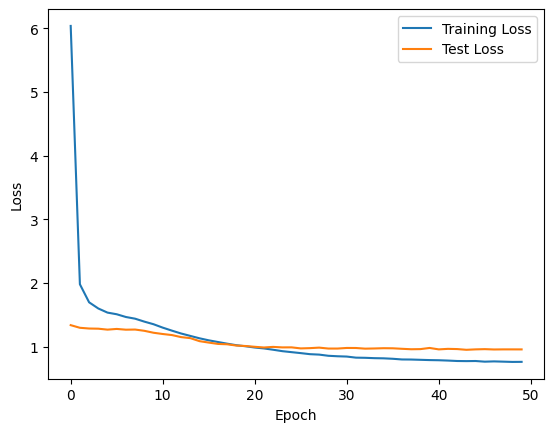

In [16]:
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Outcome Visualization

In [17]:
print('Train Dataset Length: ', len(train_dataset))
print('Test Dataset Length: ', len(test_dataset))

Train Dataset Length:  80000
Test Dataset Length:  20000


In [18]:
for _ in range(5):
    user_id, item_id, rating = random.choice(test_dataset)
    user_id = torch.tensor([user_id]).to(device)
    item_id = torch.tensor([item_id]).to(device)
    rating = torch.tensor([rating]).to(device)
    output = model(user_id, item_id)
    print(f'User: {user_id.item()}, Item: {item_id.item()}, Actual Rating: {rating.item()}, Predicted Rating: {output.item()}')

User: 505, Item: 403, Actual Rating: 2, Predicted Rating: 2.3344979286193848
User: 188, Item: 360, Actual Rating: 4, Predicted Rating: 2.898597240447998
User: 229, Item: 487, Actual Rating: 3, Predicted Rating: 3.7964303493499756
User: 102, Item: 114, Actual Rating: 3, Predicted Rating: 2.7912065982818604
User: 153, Item: 311, Actual Rating: 3, Predicted Rating: 3.6975650787353516


# Recommender Test

In [19]:
movies = pd.read_csv('ml-100k/movies.csv', index_col='movieId')
movies.head()

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy


In [20]:
movies.loc[[1]]['title'].values[0]

'Toy Story (1995)'

### New User Test

In [23]:
# Create X random interactions
num_interaction = 10
new_user_id = len(user_ids)
random_item_ids = np.random.choice(item_ids.cpu(), num_interaction)
random_ratings = np.random.randint(1, 6, num_interaction)

# Predict for new user
model.eval()
all_item_ids = torch.arange(len(item_ids)).to(device)
user_ids = torch.full((len(item_ids),), new_user_id).to(device, dtype=torch.long)
with torch.no_grad():
    outputs = model(user_ids, all_item_ids).cpu().numpy()

# Get the top 10 recommendations
top_10 = np.argsort(outputs)[::-1][:10]
print('Top 10 Recommendations:')
for item_id in top_10:
    movie = movies.loc[[item_id]]['title'].values[0]
    print(f'Movie: {movie}, Item ID: {item_id}, Predicted Rating: {outputs[item_id]}')


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

### New Movie Test

In [ ]:
# Create X random interactions
num_interaction = 10
new_item_id = len(item_ids)
random_user_ids = np.random.choice(user_ids.cpu(), num_interaction)
random_ratings = np.random.randint(1, 6, num_interaction)

# Predict for new item
model.eval()
all_user_ids = torch.arange(len(user_ids)).to(device)
item_ids = torch.full((len(user_ids),), new_item_id).to(device, dtype=torch.long)
with torch.no_grad():
    outputs = model(all_user_ids, item_ids).cpu().numpy()

# Get the top 10 recommendations
top_10 = np.argsort(outputs)[::-1][:10]
print('Top 10 Users to recommend to:')
for user_id in top_10:
    print(f'User ID: {user_id}, Predicted Rating: {outputs[user_id]}')

Top 10 Users to recommend to:
User ID: 18, Predicted Rating: 4.03505277633667
User ID: 2, Predicted Rating: 4.024545669555664
User ID: 1, Predicted Rating: 4.02407169342041
User ID: 5, Predicted Rating: 4.002097129821777
User ID: 12, Predicted Rating: 3.999988079071045
User ID: 3, Predicted Rating: 3.998711585998535
User ID: 31, Predicted Rating: 3.989100933074951
User ID: 9, Predicted Rating: 3.9579617977142334
User ID: 15, Predicted Rating: 3.942776918411255
User ID: 20, Predicted Rating: 3.942246675491333
